### モジュールインポート

In [1]:
import csv
import requests
import bs4
import re
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
import derby_func as func
import collections
from sklearn import preprocessing

C:\Users\mano2\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### 定数宣言

In [2]:
RACE_NAME = "有馬記念"
RACE_NAME_2 = "有馬記念"
RACE = "/race/"
CSV_DIR = "csv"
URL_BASE = "https://db.netkeiba.com"
URL_RACE = "https://race.netkeiba.com/race/shutuba.html?race_id="

RACE_TABLE_NAME = "race_table_01 nk_tb_common"

In [58]:
TRAIN_RACE_DATA_PATH = CSV_DIR+ RACE + RACE_NAME + "/"
TRAIN_HORSE_DATA_PATH = CSV_DIR + "/horse/"
# min_cnt = 1で2021のレースは含まない, max_cnt = nとすることで過去のnレースをトレインデータにする
TRAIN_RACE_ID = func.get_train_race_id(func.get_text_from_page('https://race.netkeiba.com/special/index.html?id=0133'), min_cnt =0, max_cnt = 11)
RACE_DATA_COLUMNS = func.race_data_columns()
HORSE_DATA_COLUMNS = func.horse_data_columns()
RACE_RANK = func.race_rank()

In [59]:
TRAIN_RACE_ID

['202106050811',
 '202006050811',
 '201906050811',
 '201806050811',
 '201706050811',
 '201606050910',
 '201506050810',
 '201406040810',
 '201306050810',
 '201206050810',
 '201106050810']

In [60]:
len(TRAIN_RACE_ID)

11

### DataFrame読み込み、前処理

In [61]:
df_races = []
db_horses = {}
for i in range(len(TRAIN_RACE_ID)):
    df_races.append(pd.read_csv(TRAIN_RACE_DATA_PATH + str(int(TRAIN_RACE_ID[len(TRAIN_RACE_ID) - 1][:4]) + i) + ".csv", header=None, names = RACE_DATA_COLUMNS, encoding='shift_jis'))

In [62]:
len(df_races)

11

In [63]:
def race_score_define(row):
    rank_score = 0
    for rank in RACE_RANK:
        if (rank.rank in row['race_name']):
            rank_score = rank.score
    return rank_score

In [64]:
def load_horse_data(row, num):
    load_path = TRAIN_HORSE_DATA_PATH + str(int(TRAIN_RACE_ID[len(TRAIN_RACE_ID) - 1][:4]) + int(num)) + RACE_NAME + "/" + row['horse_name'] + ".csv"
    path = str(int(TRAIN_RACE_ID[len(TRAIN_RACE_ID) - 1][:4]) + int(num)) + row['horse_name']
    df_tmp = pd.read_csv(load_path, header=None, names = HORSE_DATA_COLUMNS, encoding='shift_jis')
    df_tmp = df_tmp.drop(columns=['time_score', "ground_score", 'popularity', 'odds', 'R', 'winner', 'reward', "video" ,"coment", "coment_2",])
    df_tmp.dropna(how='all', axis = 1, inplace=True)
    df_tmp['ground_type'] = df_tmp.apply(lambda x: x['distance'][:1], axis = 1)
    df_tmp['distance'] = df_tmp.apply(lambda x: x['distance'][1:], axis = 1)
    df_tmp['race_rank_score'] = df_tmp.apply(race_score_define, axis = 1)
    df_tmp.dropna(how='any', axis = 0, inplace=True)
    db_horses[path] = df_tmp.reset_index()
    return path

In [65]:
def serch_past_races(row, num):
    df_horse = db_horses[row['horse_data_key']]
    df_horse['race_date_judge'] = df_horse.apply(lambda x: True if str(x['race_id']) == str(TRAIN_RACE_ID[len(TRAIN_RACE_ID) - 1 - num]) else False, axis = 1)
    index = df_horse[df_horse['race_date_judge'] == True].index
    df_horse = df_horse.iloc[index[0] + 1:]
    db_horses[row['horse_data_key']] = df_horse
    if (df_horse.shape[0] > 0):
        return index[0]
    else :
        return 0

In [66]:
def rank_to_int(df):
    df_2 = df.copy()
    df_2 = df_2[(df_2['rank'] != "取") & (df_2['rank'] != "中") & (df_2['rank'] != "除") & (df_2['rank'] != "失")]
    df_2['rank'] = df_2['rank'].apply(lambda x: int(re.sub(r"\D", "", str(x))))
    return df_2

In [67]:
def calc_past_rank_ave(row):
    df_horse = db_horses[row['horse_data_key']]
    df_horse = rank_to_int(df_horse)
    df_horse['race_score'] = df_horse.apply(lambda x: 0 if x['rank'] > 5 else (x['race_rank_score'] * (4 - x['rank']) * 10) / x['head_count'], axis = 1)
    mean = df_horse['rank'].mean(axis = 0)
    db_horses[row['horse_data_key']] = df_horse
    return mean

In [68]:
def feature_creation(df_race_tmp, num = 1):
    df = df_race_tmp.copy()
    df = df[df['race_count'] > 0]
    df['past_rank_ave'] = df.apply(calc_past_rank_ave, axis = 1)
    df['before_race_rank'] = df.apply(lambda x: int(db_horses[x['horse_data_key']]['rank'][x['race_count'] + num]), axis = 1)
    df['past_rank_std'] = df.apply(lambda x: db_horses[x['horse_data_key']]['rank'].std(axis = 0), axis = 1)
    df['ave_race_score'] = df.apply(lambda x: db_horses[x['horse_data_key']]['race_score'].median(axis = 0), axis = 1)
    return df.fillna(0)

In [69]:
df_races_2 = df_races.copy()
drop_columns = ['trainer', 'owner', 'jockey', 'reward', 'difference', 'lap_time', 'final_3F', 'time', 'time_score']
for i in range(len(TRAIN_RACE_ID)):
    df_races_2[i].fillna({'time_score': '**'})
    df_races_2[i].dropna(how='all', axis = 1, inplace=True)
    df_races_2[i] = rank_to_int(df_races_2[i])
    df_races_2[i] = df_races_2[i].drop(columns = drop_columns, errors = 'ignore')
    df_races_2[i]['horse_data_key'] = df_races_2[i].apply(load_horse_data, num = i, axis = 1)
    df_races_2[i]['race_count'] = df_races_2[i].apply(serch_past_races, num = i, axis = 1)
    df_races_2[i] = feature_creation(df_races_2[i])
df_races_2[0].head(5)

,rank,frame_number,horse_number,horse_name,aptitude_course,aptitude_distance,aptitude_run,aptitude_growth,aptitude_ground,age,weight,odds,popularity,horse_weight,horse_data_key,race_count,past_rank_ave,before_race_rank,past_rank_std,ave_race_score
0,1,6,9,オルフェーヴル,110,43,9,42,101,牡3,55,2.2,1.0,462(-4),2011オルフェーヴル,6,2.300000,1,2.790858,108.333333
1,2,4,5,エイシンフラッシュ,110,44,24,59,79,牡4,57,26.8,7.0,488(-4),2011エイシンフラッシュ,9,3.666667,8,2.609506,40.000000
2,3,5,7,トゥザグローリー,90,53,62,41,67,牡4,57,47.1,9.0,536(+12),2011トゥザグローリー,16,4.625000,11,4.379878,23.437500
3,4,8,14,ルーラーシップ,107,50,35,35,76,牡4,57,52.9,11.0,504(+6),2011ルーラーシップ,6,2.636364,5,2.110579,21.428571
4,5,6,10,トーセンジョーダン,109,42,81,43,62,牡5,57,9.2,3.0,482(+4),2011トーセンジョーダン,12,2.588235,2,2.373258,64.285714


### レースの特徴表示

In [70]:
df_all_races = pd.concat(df_races_2)
len(df_all_races)

135

In [71]:
df_all_races_rank = []
df_all_races_rank.append(df_all_races[df_all_races['rank'] == 1])
df_all_races_rank.append(df_all_races[df_all_races['rank'] <= 3])
df_all_races_rank.append(df_all_races)

In [72]:
def plot_count_columns(column_name, _bins = 20, _range = (0, 20)):
    titles = ["Rank1", "InTicket", "All"]
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(df_all_races_rank)):
        plt.subplot(len(df_all_races_rank), 3, i+1)
        plt.title(titles[i] + "_" + column_name)
        plt.hist(df_all_races_rank[i][column_name], bins=_bins, range = _range)
        plt.tight_layout()
        print(titles[i] + "：サンプル数" + str(len(df_all_races_rank[i])))
    plt.style.use('default')
    plt.savefig(f"images/{column_name}.png", bbox_inches='tight')

過去20年で1着及び馬券内だった馬の枠番

Rank1：サンプル数7
InTicket：サンプル数23
All：サンプル数135


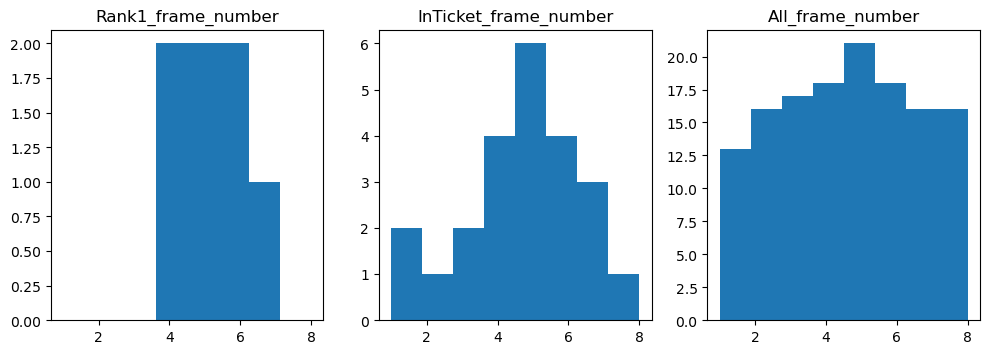

In [73]:
plot_count_columns('frame_number', 8, (1, 8))

過去20年で1着及び馬券内だった馬の芝適性

Rank1：サンプル数7
InTicket：サンプル数23
All：サンプル数135


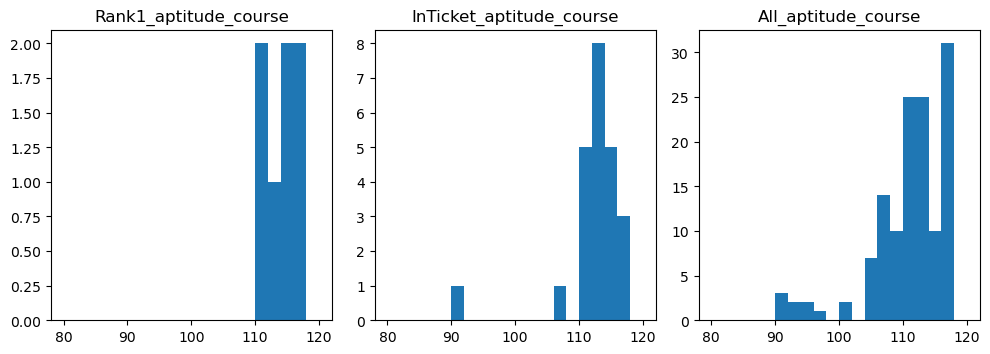

In [74]:
plot_count_columns("aptitude_course", _range = (80, 120))

過去20年で1着及び馬券内だった馬の距離適性(高いほど短距離得意)

Rank1：サンプル数7
InTicket：サンプル数23
All：サンプル数135


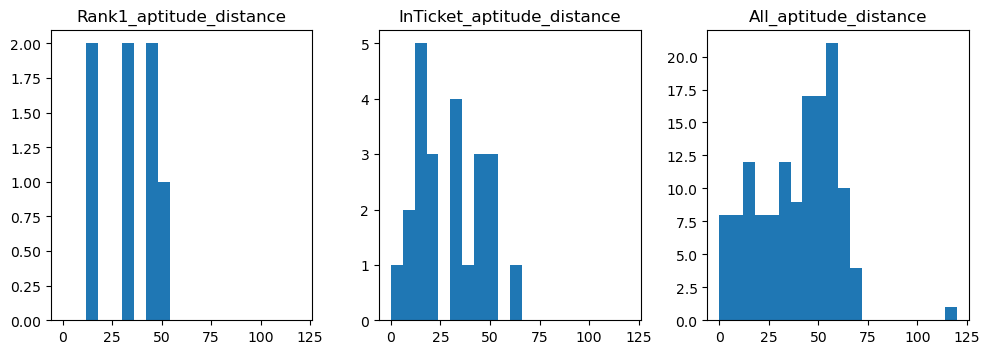

In [75]:
plot_count_columns("aptitude_distance", _range = (0, 120))

過去20年で1着及び馬券内だった馬の脚質適性(高いほど逃げ)

Rank1：サンプル数7
InTicket：サンプル数23
All：サンプル数135


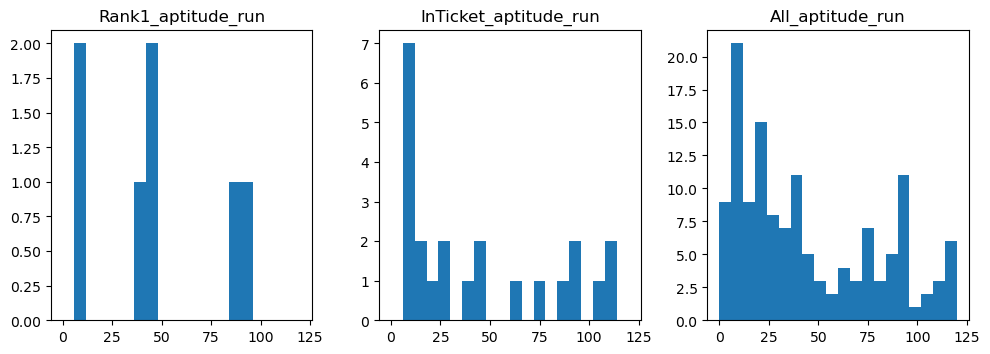

In [76]:
plot_count_columns("aptitude_run", _range = (0, 120))

過去20年で1着及び馬券内だった馬の成長適性(高いほど早熟)

Rank1：サンプル数7
InTicket：サンプル数23
All：サンプル数135


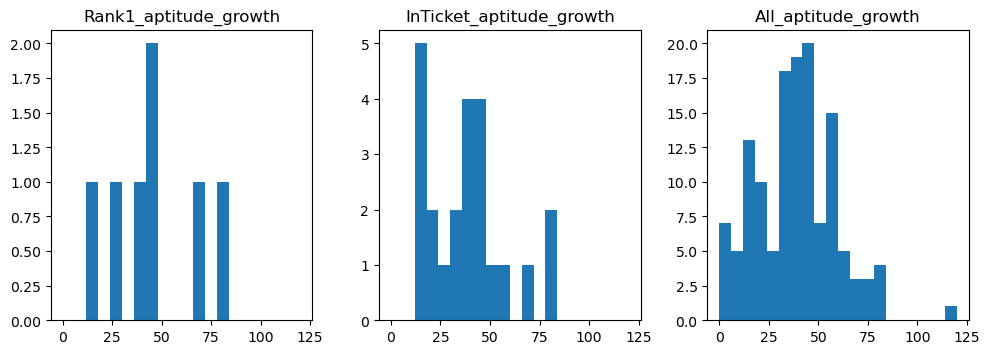

In [77]:
plot_count_columns("aptitude_growth", _range = (0, 120))

過去20年で1着及び馬券内だった馬の馬場適性(高いほど重馬場得意)

Rank1：サンプル数7
InTicket：サンプル数23
All：サンプル数135


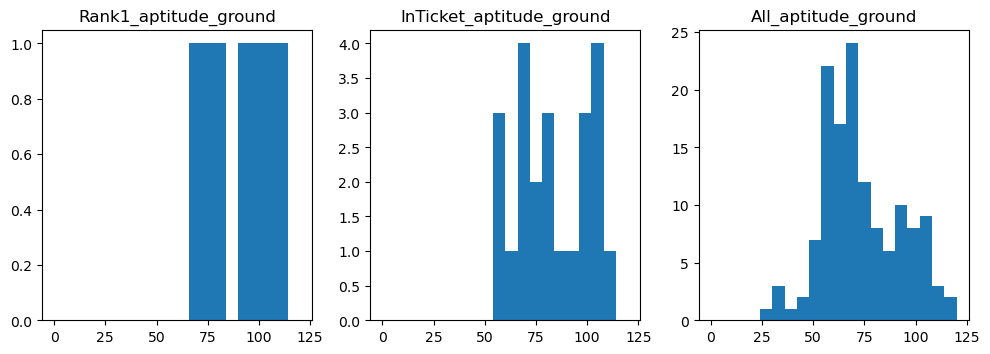

In [78]:
plot_count_columns("aptitude_ground", _range = (0, 120))

過去20年で1着及び馬券内だった馬の過去レース順位平均値

Rank1：サンプル数7
InTicket：サンプル数23
All：サンプル数135


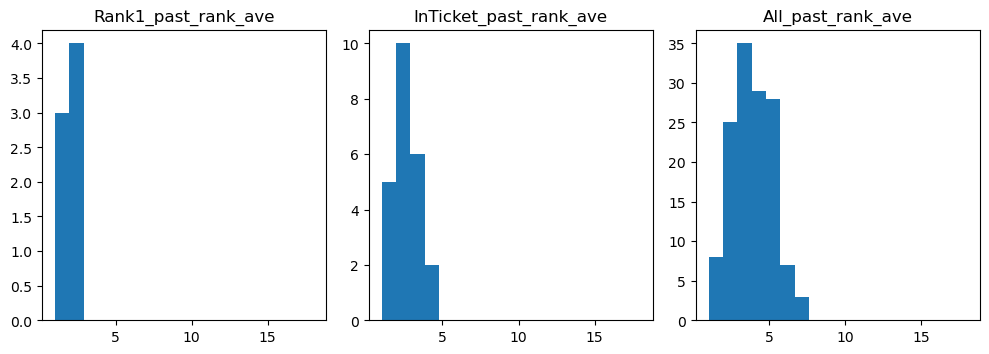

In [79]:
plot_count_columns("past_rank_ave", 18,_range = (1, 18))

過去20年で1着及び馬券内だった馬の前走着順

Rank1：サンプル数7
InTicket：サンプル数23
All：サンプル数135


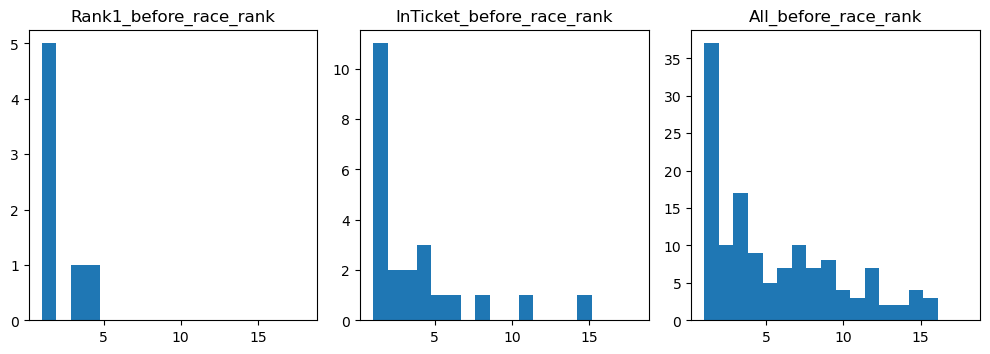

In [80]:
plot_count_columns("before_race_rank", 18,_range = (1, 18))

過去レースの順位データに(G1)などのレースの格を数値化して計算した平均を算出

Rank1：サンプル数7
InTicket：サンプル数23
All：サンプル数135


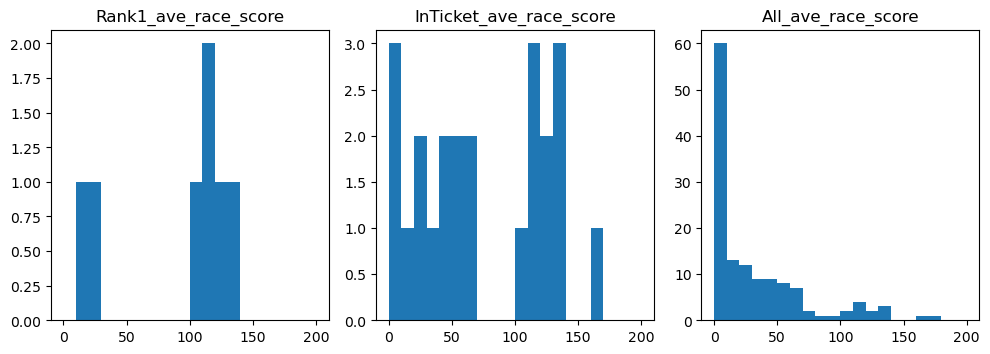

In [81]:
plot_count_columns("ave_race_score", _range = (0, 200))

### 特徴量抽出

In [82]:
df_races_train = []
df_races_test = []
df_races_all = pd.concat(df_races_2)
for i in range(len(df_races_2)):
    tmp = []
    for j in range(len(df_races_2)):
        if (i == j):
            df_races_test.append(df_races_2[j])
        else:
            tmp.append(df_races_2[j])
    df_races_train.append(pd.concat(tmp))

In [83]:
df_races_train_2 = df_races_train.copy()
df_races_test_2 = df_races_test.copy()
df_races_all_2 = df_races_all.copy()
y_trains = []
(df_races_all_2, y_all) = func.create_param(df_races_all_2)
for i in range(len(df_races_train_2)):
    (df_races_train_2[i], df_races_test_2[i], tmp) = func.create_params(df_races_train_2[i], df_races_test_2[i])
    y_trains.append(tmp)

### 2000～2019までのデータで2020年のレースを予測してみて正答率を確認する

In [88]:
TEST_NUM = 10

In [89]:
df_races_test_2[0].head(1)

,frame_number,aptitude_course,aptitude_distance,aptitude_run,aptitude_growth,aptitude_ground,weight,race_count,past_rank_ave,before_race_rank,past_rank_std,ave_race_score
0,6,110,43,9,42,101,55,6,2.3,1,2.790858,108.333333


In [90]:
y_train = y_trains[TEST_NUM]

In [91]:
X_train = df_races_train_2[TEST_NUM].values.astype(np.float)
X_train.shape

(123, 12)

In [92]:
X_test = df_races_test_2[TEST_NUM].values.astype(np.float)
X_test.shape

(12, 12)

In [93]:
mm = preprocessing.MinMaxScaler()
X_train = mm.fit_transform(X_train)
X_test = mm.fit_transform(X_test)

### 機械学習開始

In [94]:
# 機械学習のモデルを読み込む
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model

# 機械学習のお役立ちモジュールを読み込む
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [95]:
def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = StratifiedKFold(n_splits = n_folds, shuffle = shuffle).split(X, y)
    y_pred = y.copy()
    for ii, jj in stratified_k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train, y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

5つの学習モデルで正答率比較　(Dump Classifierはすべての入力に0を返すモデル)

In [96]:
print('Passive Aggressive Classifier: {:.3f}'.format(metrics.accuracy_score(y_train, stratified_cv(X_train, y_train, linear_model.PassiveAggressiveClassifier))))
print('Gradient Boosting Classifier:  {:.3f}'.format(metrics.accuracy_score(y_train, stratified_cv(X_train, y_train, ensemble.GradientBoostingClassifier))))
print('Support vector machine(SVM):   {:.3f}'.format(metrics.accuracy_score(y_train, stratified_cv(X_train, y_train, svm.SVC))))
print('Random Forest Classifier:      {:.3f}'.format(metrics.accuracy_score(y_train, stratified_cv(X_train, y_train, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier: {:.3f}'.format(metrics.accuracy_score(y_train, stratified_cv(X_train, y_train, neighbors.KNeighborsClassifier))))
print('Dump Classifier: {:.3f}'.format(metrics.accuracy_score(y_train, [0 for ii in y_train.tolist()])))

Passive Aggressive Classifier: 0.764
Gradient Boosting Classifier:  0.821
Support vector machine(SVM):   0.821
Random Forest Classifier:      0.846
K Nearest Neighbor Classifier: 0.772
Dump Classifier: 0.829


### 正答率の高かったモデルが予測時に何を重要視したかを出力

In [97]:
# linear_model.PassiveAggressiveClassifier()
# ensemble.GradientBoostingClassifier()
# svm.SVC()
# ensemble.RandomForestClassifier()
# neighbors.KNeighborsClassifier()

model = ensemble.RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

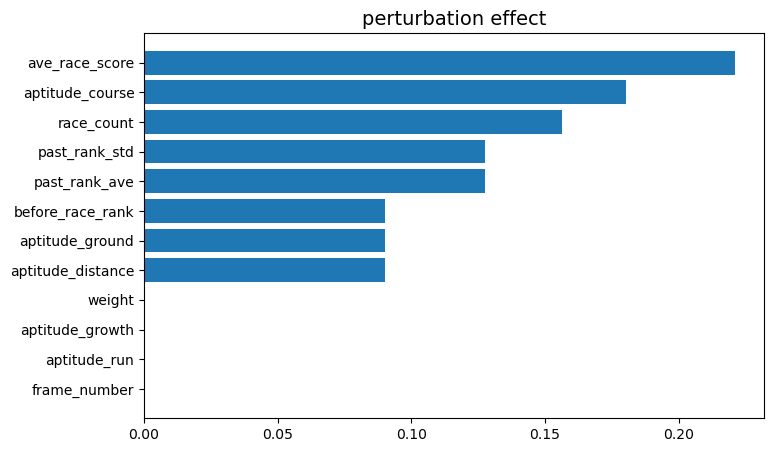

ave_race_score, perturbation effect: 20.66%
past_rank_ave, perturbation effect: 19.48%
aptitude_course, perturbation effect: 16.87%
aptitude_ground, perturbation effect: 9.74%
race_count, perturbation effect: 9.74%
past_rank_std, perturbation effect: 9.74%
aptitude_ground, perturbation effect: 6.89%
race_count, perturbation effect: 6.89%
past_rank_std, perturbation effect: 0.00%
aptitude_ground, perturbation effect: 0.00%
race_count, perturbation effect: 0.00%
past_rank_std, perturbation effect: 0.00%


In [98]:
func.plot_importance(func.calc_importance(model, X_train), df_races_test_2[0].columns.values)
func.print_importance(func.calc_importance(model, X_train), df_races_test_2[0].columns.values)

予測結果出力

In [99]:
y_pred = model.predict(X_test)
print(y_pred)
for i in range(len(y_pred)):
    if (y_pred[i]):
        print(df_races_2[TEST_NUM].iloc[[i]]['horse_name'])

[0 0 0 0 0 0 0 0 0 0 0 0]


### 今年のレースを予測

In [100]:
PRED_RACE_COLUMNS = [
    "frame_number",
    "horse_number",
    "mark",
    "horse_name",
    "url",
    "aptitude_course",
    "aptitude_distance",
    "aptitude_run",
    "aptitude_growth",
    "aptitude_ground",
    "age",
    "weight",
    "jockey",
    "trainer",
    "blank_1",
    "blank_2",
    "blank_3",
    "blank_4",
    "blank_5"
]

In [101]:
TRAIN_RACE_ID[0]

'202106050811'

In [102]:
RACE_NAME = RACE_NAME_2

In [103]:
df_pred_race = pd.read_csv(CSV_DIR+ RACE + str(int(TRAIN_RACE_ID[0][:4]) + 1) + RACE_NAME_2 + ".csv", header=None, names = PRED_RACE_COLUMNS, encoding='shift_jis')

In [107]:
num = 11
df_pred_race.head(5)

,frame_number,horse_number,mark,horse_name,url,aptitude_course,aptitude_distance,aptitude_run,aptitude_growth,aptitude_ground,age,weight,jockey,trainer,blank_1,blank_2,blank_3,blank_4,blank_5
0,1,1,--◎◯▲△☆&#10003消,アカイイト,https://db.netkeiba.com/horse/2017106203,111,29,12,21,108,牝5,55.0,幸,栗東中竹,NaN,---.-,**,NaN,NaN
1,1,2,--◎◯▲△☆&#10003消,イズジョーノキセキ,https://db.netkeiba.com/horse/2017102294,116,58,1,1,58,牝5,55.0,岩田康,栗東石坂,NaN,---.-,**,NaN,NaN
2,2,3,--◎◯▲△☆&#10003消,ボルドグフーシュ,https://db.netkeiba.com/horse/2019104909,116,1,1,19,58,牡3,55.0,福永,栗東宮本,NaN,---.-,**,NaN,NaN
3,2,4,--◎◯▲△☆&#10003消,アリストテレス,https://db.netkeiba.com/horse/2017105525,116,5,73,32,52,牡5,57.0,武豊,栗東音無,NaN,---.-,**,NaN,NaN
4,3,5,--◎◯▲△☆&#10003消,ジェラルディーナ,https://db.netkeiba.com/horse/2018105081,116,58,11,1,58,牝4,55.0,Ｃデムーロ,栗東斉藤崇,NaN,---.-,**,NaN,NaN


In [108]:
df_pred_race_2 = df_pred_race.copy()
drop_columns = ['trainer', 'owner', 'jockey', 'mark', 'url', 'blank_1', 'blank_2', 'blank_3', 'blank_4', 'blank_5']
df_pred_race_2.fillna({'time_score': '**'})
df_pred_race_2.dropna(how='all', axis = 1, inplace=True)
df_pred_race_2 = df_pred_race_2.drop(columns = drop_columns, errors = 'ignore')
df_pred_race_2['horse_data_key'] = df_pred_race_2.apply(load_horse_data, num = num, axis = 1)
df_pred_race_2['race_count'] = df_pred_race_2.apply(lambda x: int(db_horses[x['horse_data_key']].shape[0]), axis = 1)
df_pred_race_2 = feature_creation(df_pred_race_2, -1)

In [109]:
df_pred_race_2.head(5)

,frame_number,horse_number,horse_name,aptitude_course,aptitude_distance,aptitude_run,aptitude_growth,aptitude_ground,age,weight,horse_data_key,race_count,past_rank_ave,before_race_rank,past_rank_std,ave_race_score
0,1,1,アカイイト,111,29,12,21,108,牝5,55.0,2022アカイイト,26,4.269231,4,2.793674,0.000000
1,1,2,イズジョーノキセキ,116,58,1,1,58,牝5,55.0,2022イズジョーノキセキ,22,3.681818,6,2.417917,6.250000
2,2,3,ボルドグフーシュ,116,1,1,19,58,牡3,55.0,2022ボルドグフーシュ,9,3.000000,6,2.179449,37.500000
3,2,4,アリストテレス,116,5,73,32,52,牡5,57.0,2022アリストテレス,18,4.722222,2,4.443178,11.868687
4,3,5,ジェラルディーナ,116,58,11,1,58,牝4,55.0,2022ジェラルディーナ,16,3.437500,3,2.874456,9.687500


In [110]:
df_pred_race_3 = df_pred_race_2.copy()
df_pred_race_3 = df_pred_race_3.drop(columns = ["horse_name", "age", "horse_data_key", "horse_number"])
df_pred_race_3.head(1)

,frame_number,aptitude_course,aptitude_distance,aptitude_run,aptitude_growth,aptitude_ground,weight,race_count,past_rank_ave,before_race_rank,past_rank_std,ave_race_score
0,1,111,29,12,21,108,55.0,26,4.269231,4,2.793674,0.0


In [111]:
df_pred_race_3.shape
x_pred = df_pred_race_3.values.astype(np.float)

In [112]:
X_all = df_races_all_2.values.astype(np.float)

In [113]:
X_all = mm.fit_transform(X_all)
x_pred = mm.fit_transform(x_pred)

In [114]:
horse_names = df_pred_race_2['horse_name']
models = []
models.append(linear_model.PassiveAggressiveClassifier())
models.append(ensemble.GradientBoostingClassifier())
models.append(svm.SVC())
models.append(ensemble.RandomForestClassifier())
models.append(neighbors.KNeighborsClassifier())
names = []
preds = np.zeros(len(horse_names), dtype=np.int64)
for _ in range(100):
    for i in range(len(models)):
        models[i].fit(X_all, y_all)
        y_pred = models[i].predict(x_pred)
        preds = preds + y_pred
        for j in range(len(y_pred)):
            if (y_pred[j]):
                names.append(horse_names[j])
print(preds.tolist())
print(collections.Counter(names))

[0, 0, 10, 11, 0, 47, 172, 1, 48, 2, 1, 11, 261, 52, 18, 17]
Counter({'タイトルホルダー': 261, 'エフフォーリア': 172, 'ボッケリーニ': 52, 'イクイノックス': 48, 'ヴェラアズール': 47, 'ブレークアップ': 18, 'ディープボンド': 17, 'アリストテレス': 11, 'ポタジェ': 11, 'ボルドグフーシュ': 10, 'ジャスティンパレス': 2, 'ウインマイティー': 1, 'ラストドラフト': 1})
